In [1]:
import numpy as np
import gpstk
from GNSS_TK1 import *
import matplotlib.pyplot as plt
%matplotlib inline

##Iono gradient WOOS/GARF PRN 26 20.7-21.3 hours 11/20/2003

In [2]:
st1=["data/woos324.03.n","data/woos324.03.o"]
st2=["data/garf324.03.n","data/garf3240.03o"]
t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2,__,__,__,__=getdata_stationpair(st1,st2,"GPS 26")

In [3]:
print len(IPP1),len(t1),len(Icode1),len(Iphase1),len(VTECphase1),len(ELEV1)
print len(IPP2),len(t2),len(Icode2),len(Iphase2),len(VTECphase2),len(ELEV2)
print min(t1),max(t1)
print min(t2),max(t2)

757 757 757 757 757 757
761 761 761 761 761 761
14459.0 77519.0
14580.0 77550.0


###Sync times (Since times in st1 en st2 are a little different)

In [4]:
tiempos1=get_obstimes(t1,74520,76680)
tiempos2=get_obstimes(t2,74520,76680)
#Nos quedamos con los datos entre las 20.7 y 21.3 horas
print len(tiempos1),len(tiempos2)
tiempos1=adjust_times(tiempos1)
print len(tiempos1),len(tiempos2)

72 73
72 73


###Specific Arc

In [5]:
tcommon=np.intersect1d(tiempos1,tiempos2)
print "Observations: ",np.size(tcommon)

Observations:  72


###First Results: Ploting raw  delay data: Slant ZOB - GARF

In [6]:
D=[]
gg=[]#gradient
IC1,IC2,IPh1,IPh2,IPPs1,IPPs2=[],[],[],[],[],[]
t,EL1,EL2=[],[],[]
print  IPP1[tcommon[0]-1][0] #desfase de 1 segundo

-235015.098013


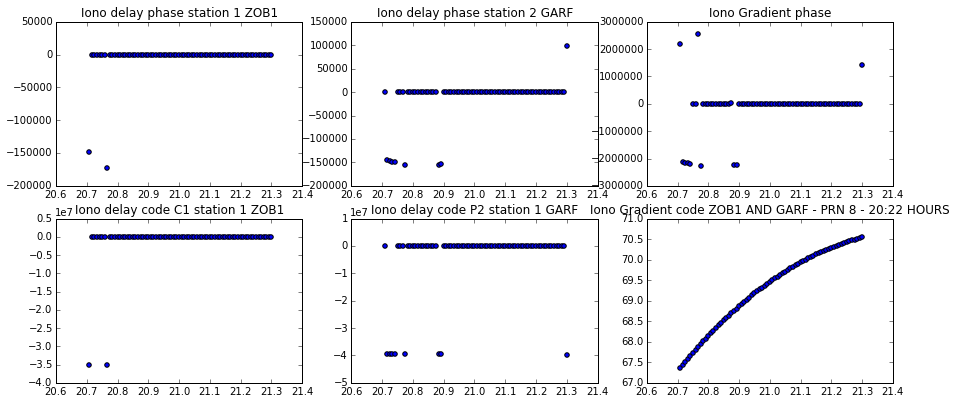

In [7]:
for time in tcommon:
    d=np.sqrt((IPP1[time-1][0]-IPP2[time][0])**2+(IPP1[time-1][1]-IPP2[time][1])**2+(IPP1[time-1][2]-IPP2[time][2])**2)
    #if Iphase1[time-1]>-200000 and Iphase1[time-1]<0 and Iphase2[time]>-2000 and Iphase2[time]<100000 : #ese errorcito se soluciona bajando el umbral en getdata
    D.append(d)
    EL1.append(ELEV1[time-1])
    EL2.append(ELEV2[time])
    IC1.append(Icode1[time-1])
    IC2.append(Icode2[time])
    IPh1.append(Iphase1[time-1])
    IPh2.append(Iphase2[time])
    t.append(time)

D=np.array(D)/1000 #Distance between IPP's in Km
t=np.array(t)/3600 #time in hours
IC1=np.array(IC1)
IC2=np.array(IC2)
IP1=np.array(IPh1)
IP2=np.array(IPh2)
EL1=np.array(EL1)
EL2=np.array(EL2)

plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title("Iono delay phase station 1 ZOB1")
plt.scatter(t,IP1)
plt.subplot(3,3,2)
plt.title("Iono delay phase station 2 GARF")
plt.scatter(t,IP2)
plt.subplot(3,3,3)
plt.title("Iono Gradient phase")
DelayP=((IP2-IP1)*1000)/D #Km/mm
plt.scatter(t,DelayP)
plt.subplot(3,3,4)
plt.title("Iono delay code C1 station 1 ZOB1")
plt.scatter(t,IC1)
plt.subplot(3,3,5)
plt.title("Iono delay code P2 station 1 GARF")
plt.scatter(t,IC2)
plt.subplot(3,3,6)
plt.title("Iono Gradient code ZOB1 AND GARF - PRN 8 - 20:22 HOURS")
DelayC=((IC1-IC2)*1000)/D
plt.scatter(t,D)

#IOD Cycle Slips
<br> First jumps bigger than **2.5** meters in adjacent data are detcted on each station.

In [8]:
jumps1=datajump(IP1,t,2.5) 
print "Data jumps in slant delay station1 : ",jumps1

jumps2=datajump(IP2,t,2.5) 
print "Data jumps in  in slant delay station2: ",jumps2

Data jumps in slant delay station1 :  [1 8]
Data jumps in  in slant delay station2:  [ 5  9 20 22 23 71]


In [9]:
print t[jumps1]
print t[jumps2]

[ 20.71666667  20.775     ]
[ 20.75        20.78333333  20.875       20.89166667  20.9         21.3       ]


##This Continuous arc is divided into "several" subarcs
Using de datajumps we split our arc into miniarcs

In [10]:
miniarcs1=sub_arcs(IP1,jumps1)
print "Total subarcs=",len(miniarcs1)
for i in range(len(miniarcs1)):
    print "Arc ",i," has ",len(miniarcs1[i])," elements"

Total subarcs= 3
Arc  0  has  1  elements
Arc  1  has  7  elements
Arc  2  has  64  elements


In [11]:
miniarcs2=sub_arcs(IP2,jumps2)
print "Total subarcs=",len(miniarcs2)
for i in range(len(miniarcs2)):
    print "Arc ",i," has ",len(miniarcs2[i])," elements" 

Total subarcs= 7
Arc  0  has  5  elements
Arc  1  has  4  elements
Arc  2  has  11  elements
Arc  3  has  2  elements
Arc  4  has  1  elements
Arc  5  has  48  elements
Arc  6  has  1  elements


##Short arc Removal
Also, miniarcs with less than 10 elements, or five minutes are removed. **The short arcs need to be discarded because leveling errors for those arcs are typically large and cause ionospheric delay estimation errors. **

In [12]:
print "Estacion 1 subarcos",miniarcs1
print "Estacion 2 subarcos",miniarcs2

Estacion 1 subarcos [array([0]), array([1, 2, 3, 4, 5, 6, 7]), array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71])]
Estacion 2 subarcos [array([0, 1, 2, 3, 4]), array([5, 6, 7, 8]), array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), array([20, 21]), array([22]), array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]), array([71])]


In [13]:
print len(IP1),len(IC1),len(IP2),len(IC2),len(t),len(D)
miniarcs1,miniarcs2=remove_short(miniarcs1,miniarcs2)
print len(IP1),len(IC1),len(IP2),len(IC2),len(t),len(D)

72 72 72 72 72 72
SubArc #  0
Sub-Arcs deleted 0 [0]
SubArc #  1
Sub-Arcs deleted 1 [1 2 3 4 5 6 7]
SubArc #  2

Deleted elements on the other station:  {0: [0, 1, 2, 3, 4], 1: [0, 1, 2]}

New # of subarcs arc1:  1

New # of subarcs of arc2 (other station):  7
72 72 72 72 72 72


In [14]:
miniarcs2,miniarcs1=remove_short(miniarcs2,miniarcs1)
print len(IP1),len(IC1),len(IP2),len(IC2),len(t),len(D)

SubArc #  0
Sub-Arcs deleted 0 []
SubArc #  1
Sub-Arcs deleted 1 [8]
SubArc #  2
SubArc #  3
Sub-Arcs deleted 3 [20 21]
SubArc #  4
Sub-Arcs deleted 4 [22]
SubArc #  5
SubArc #  6
Sub-Arcs deleted 6 [71]

Deleted elements on the other station:  {0: [0, 12, 13, 14, 63]}

New # of subarcs arc1:  2

New # of subarcs of arc2 (other station):  1
72 72 72 72 72 72


In [15]:
print miniarcs1

[ array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70])]


In [16]:
print miniarcs2

[array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
 array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70])]


##Polinomial fit & Outlier detection and Removal
###Polinomial fit

Station 1 subarcs
Biggest Slip detected with polinomyal fit:  26 21.025


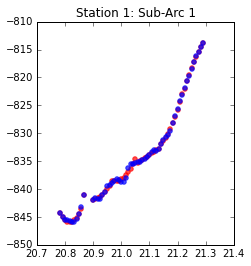

In [17]:
print "Station 1 subarcs"
plt.figure(figsize=(12,4))
P11,pslip11=poly_fit(IP1[miniarcs1[0]],t[miniarcs1[0]])
plt.subplot(1,3,1)
plt.title("Station 1: Sub-Arc 1")
plt.scatter(t[miniarcs1[0]],P11,color="red",alpha=.7)
plt.scatter(t[miniarcs1[0]],IP1[miniarcs1[0]],color="blue",alpha=.7)
print "Biggest Slip detected with polinomyal fit: ",pslip11,t[miniarcs1[0]][pslip11] 


Station 2 subarcs
Biggest Slip detected with polinomyal fit:  None [[ 20.78333333  20.79166667  20.8         20.80833333  20.81666667  20.825
   20.83333333  20.84166667  20.85        20.85833333  20.86666667]]
Biggest Slip detected with polinomyal fit:  None [[ 20.9         20.90833333  20.91666667  20.925       20.93333333
   20.94166667  20.95        20.95833333  20.96666667  20.975       20.98333333
   20.99166667  21.          21.00833333  21.01666667  21.025       21.03333333
   21.04166667  21.05        21.05833333  21.06666667  21.075       21.08333333
   21.09166667  21.1         21.10833333  21.11666667  21.125       21.13333333
   21.14166667  21.15        21.15833333  21.16666667  21.175       21.18333333
   21.19166667  21.2         21.20833333  21.21666667  21.225       21.23333333
   21.24166667  21.25        21.25833333  21.26666667  21.275       21.28333333
   21.29166667]]


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


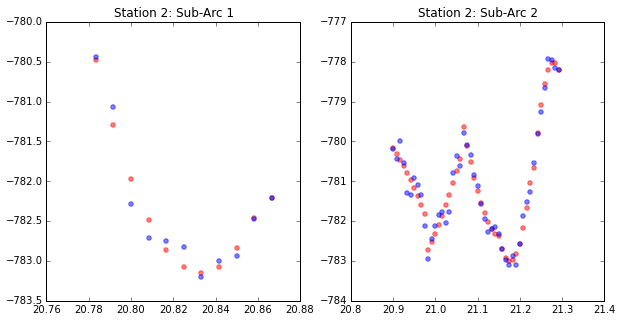

In [18]:
print "Station 2 subarcs"
plt.figure(figsize=(10,5))
P21,pslip21=poly_fit(IP2[miniarcs2[0]],t[miniarcs2[0]])
plt.subplot(1,2,1)
plt.title("Station 2: Sub-Arc 1")
plt.scatter(t[miniarcs2[0]],P21,color="red",alpha=.5)
plt.scatter(t[miniarcs2[0]],IP2[miniarcs2[0]],color="blue",alpha=.5)
print "Biggest Slip detected with polinomyal fit: ",pslip21,t[miniarcs2[0]][pslip21]

P22,pslip22=poly_fit(IP2[miniarcs2[1]],t[miniarcs2[1]])
plt.subplot(1,2,2)
plt.title("Station 2: Sub-Arc 2")
plt.scatter(t[miniarcs2[1]],P22,color="red",alpha=.5)
plt.scatter(t[miniarcs2[1]],IP2[miniarcs2[1]],color="blue",alpha=.5)
print "Biggest Slip detected with polinomyal fit: ",pslip22,t[miniarcs2[1]][pslip22]


###Outlier Factor 

In [19]:
outliers11,oslip11=outlier_detect(IP1[miniarcs1[0]],t[miniarcs1[0]]*3600)
print "Elements in OFt: ",outliers11.size
print "Biggest slip detected in: ",oslip11
print IP1[miniarcs1[0]][oslip11]
print t[miniarcs1[0]][oslip11]

Elements in OFt:  59
Biggest slip detected in:  10
-841.105250968
20.8666666667


In [20]:
outliers21,oslip21=outlier_detect(IP2[miniarcs2[0]],t[miniarcs2[0]]*3600)
print "Elements in OFt: ",outliers21.size
print "Biggest slip detected in: ",oslip21
print IP2[miniarcs2[0]][oslip21]
print t[miniarcs2[0]][oslip21]

outliers22,oslip22=outlier_detect(IP2[miniarcs2[1]],t[miniarcs2[1]]*3600)
print "Elements in OFt: ",outliers22.size
print "Biggest slip detected in: ",oslip22
print IP2[miniarcs2[1]][oslip22]
print t[miniarcs2[1]][oslip22]

Elements in OFt:  11
Biggest slip detected in:  0
-780.443914534
20.7833333333
Elements in OFt:  48
Biggest slip detected in:  10
-782.944005815
20.9833333333


##Now if the two methods detect same slip, it is confirmed and removed from both stations

In [21]:
outliers11=confirmed_slip(t[miniarcs1[0]],IP1[miniarcs1[0]])
print outliers11,len(t[miniarcs1[0]])


[] 59


In [22]:
outliers21=confirmed_slip(t[miniarcs2[0]],IP2[miniarcs2[0]])
print outliers21,len(IP2[miniarcs2[0]])

outliers22=confirmed_slip(t[miniarcs2[1]],IP2[miniarcs2[1]])  
print outliers22,len(IP2[miniarcs2[1]])

[] 11
[] 48


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


#Slip is removed from indexes so we dont count it anymore.

In [24]:
print miniarcs2

[array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
 array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70])]


In [25]:
print miniarcs1

[ array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70])]


#Leveling Phase

In [26]:

print len(t[miniarcs1[0]])
Lfactor11,new_IPHASE_arc11=levelphase(IC1[miniarcs1[0]],IP1[miniarcs1[0]],EL1[[[miniarcs1[0]]]])
print "Leveling factor: ",Lfactor11,new_IPHASE_arc11.size

59
Leveling factor:  853.312102609 59


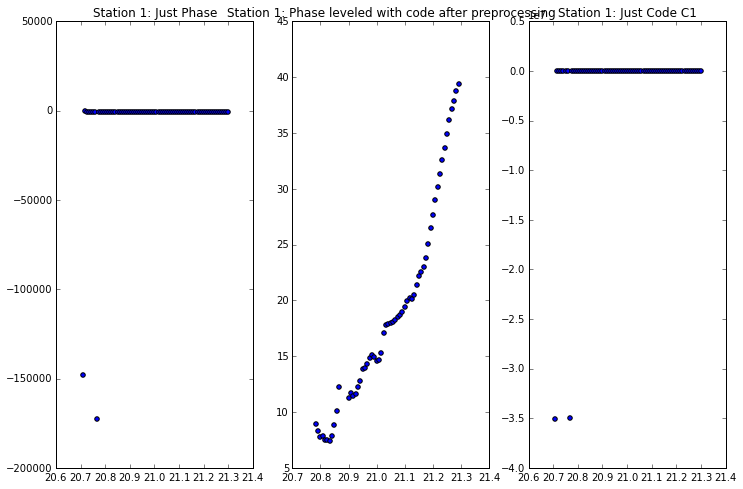

In [27]:
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title("Station 1: Just Phase")
plt.scatter(t,IP1)

plt.subplot(1,3,2)
plt.title("Station 1: Phase leveled with code after preprocessing")
plt.scatter(t[miniarcs1[0]],new_IPHASE_arc11)

plt.subplot(1,3,3)
plt.title("Station 1: Just Code C1")
plt.scatter(t,IC1)

In [28]:
print len(t[miniarcs2[0]])
Lfactor21,new_IPHASE_arc21=levelphase(IC2[miniarcs2[0]],IP2[miniarcs2[0]],EL2[miniarcs2[0]]) 
print "Leveling factor: ",Lfactor21,new_IPHASE_arc21.size

11
Leveling factor:  787.318595812 11


In [29]:
print len(t[miniarcs2[1]])
Lfactor22,new_IPHASE_arc22=levelphase(IC2[miniarcs2[1]],IP2[miniarcs2[1]],EL2[miniarcs2[1]]) 
print "Leveling factor: ",Lfactor22,new_IPHASE_arc22.size

48
Leveling factor:  787.373562169 48


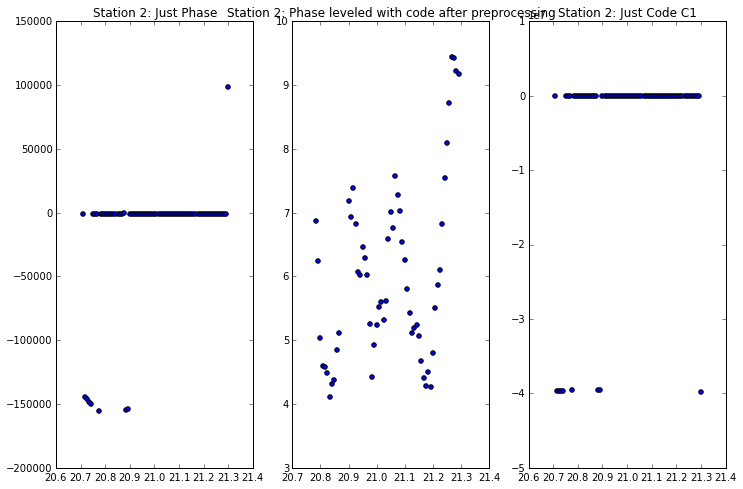

In [30]:
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title("Station 2: Just Phase")
plt.scatter(t,IP2)

plt.subplot(1,3,2)
#plt.ylim(-2,20)
plt.title("Station 2: Phase leveled with code after preprocessing")
plt.scatter(t[miniarcs2[0]],new_IPHASE_arc21)
plt.scatter(t[miniarcs2[1]],new_IPHASE_arc22)

plt.subplot(1,3,3)
plt.title("Station 2: Just Code C1")
plt.scatter(t,IC2)

#Subarcs are merged into one arc (Both stations should have same number of data points)

In [31]:
ntimes1=np.hstack((t[miniarcs1[0]])) 
new_IPHASE_arc1=np.hstack((new_IPHASE_arc11 )) 

ntimes2=np.hstack((t[miniarcs2[0]],t[miniarcs2[1]])) 
new_IPHASE_arc2=np.hstack((new_IPHASE_arc21,new_IPHASE_arc22 )) 

In [32]:
print ntimes1.size,new_IPHASE_arc1.size
print ntimes2.size,new_IPHASE_arc2.size

59 59
59 59


In [35]:
D=D[miniarcs1[0]] #slip detected and confirmed must be deleted from de IPP

59 59


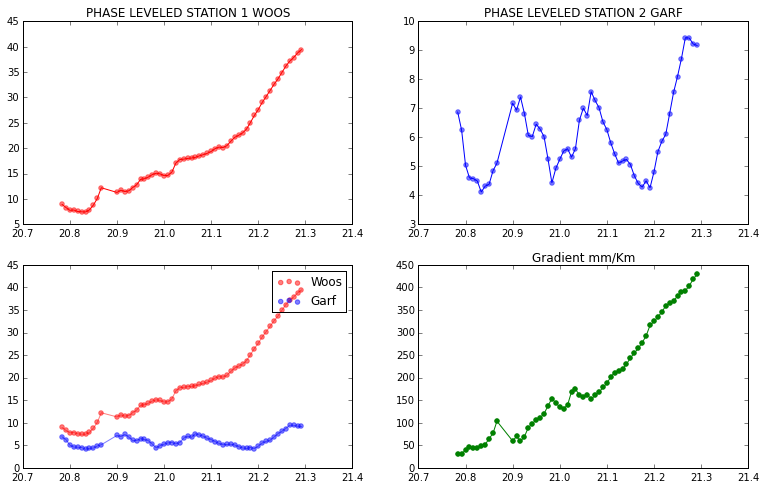

In [36]:
plt.figure(figsize=(13,8))

plt.subplot(2,2,1)
plt.title("PHASE LEVELED STATION 1 WOOS")
plt.scatter(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.plot(ntimes1,new_IPHASE_arc1,color="red")

plt.subplot(2,2,2)
plt.title("PHASE LEVELED STATION 2 GARF")
plt.scatter(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
plt.plot(ntimes2,new_IPHASE_arc2,color="blue")

plt.subplot(2,2,3)
plt.scatter(ntimes1,new_IPHASE_arc1,color="red",alpha=.5,label="Woos")
plt.plot(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.scatter(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5,label="Garf")
plt.legend()
plt.plot(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
print len(new_IPHASE_arc1),len(new_IPHASE_arc2)

plt.subplot(2,2,4)
plt.title("Gradient mm/Km")
gradient=(new_IPHASE_arc1-new_IPHASE_arc2)*1000 
plt.scatter(ntimes1,gradient/D,color="green")
plt.plot(ntimes1,gradient/D,color="green")
